# COVID-19 Auswertung - Impfungen


## import libraries

In [55]:
Programm_Name = "Impfungen" # 04.01.2021 - Time Series Impffdaten erstellen

### Speicherorte und Dateinamen Plots

In [56]:
Laufwerk = "D:\\"
pfad_output = "Github\\Auswertung_Covid_19\\output\\"
pfad_onedrive = "OneDrive\\Auswertung_Covid_19\\"
pfad_input = "Github\\Auswertung_Covid_19\\input\\"

name_input = "Impfquotenmonitoring.xlsx"
name_input2 = "02-bundeslaender.xlsx"

name_7 = "plot_7_Impfquote_ger.png" # Impfquote Deutschland Bundesländer
name_7_2 = "plot_7-2_Impfungen_Timeseries_ger.png" # Impfungen Timeseries Deutschland
name_7_3 = "plot_7-3_Impfungen_Timeseries_ger.png" # Impfungen Timeseries Deutschland
name_7_4 = "plot_7-4_Impfungen_kumuliert_Timeseries_ger.png" # Impfungen Timeseries Deutschland

name_output_df_EW = 'Dataframes\\df_EW.csv'
name_output_df_I = 'Dataframes\\df_I.csv'
name_output_df_I_EW = 'Dataframes\\df_I_EW.csv'
name_output_df_I_TS = 'Dataframes\\df_I_TS.csv'

name_performance = 'Dataframes\\df_performance.csv'

### Speicherorte und Dateinamen Plots

In [57]:
import pandas as pd #Daten
from matplotlib import pyplot as plt # plots
import matplotlib.dates as mdates
#import matplotlib as mpl
from matplotlib.ticker import FuncFormatter   # Numberformat plot ticks
import numpy as np

# performance
from datetime import datetime, timedelta
from datetime import date # todays date
#import seaborn as sns

import os
now = datetime.now()

In [58]:
# Datum einstellen 
minticks = 14
maxticks = 14

# Variablen für die Plots definieren

### Linien und Schriftgrößen

In [59]:
# Linien Stärke
lws = 3
lwb = 7
# Bezugsschriftgröße
size = 25

# output größe der bilder
h = 16*1.3
v = 9
dpi = 200

 ### Bezugsgröße Einwohner

In [60]:
pE = 100_000

## Länder Farben

In [61]:
c_fr = '#f80d0d'    # rot
c_pl = '#25e5e5'    # cyan
c_isr = '#25e5e5'
c_ger = '#0721ff'   # dunkelblau
c_cz = '#bb8fce'    # lila
c_usa = '#bb8fce'
c_at = '#18c213'    # grün
c_rus = '#18c213'
c_se = '#18c213'
c_ch = '#000000'    # schwarz
c_ita = '#000000'
c_gb = '#faac2b'    # orange


### Einwohnerzahlen

In [62]:
E_fr = 66_012_908
E_pl = 38_659_927
E_ger = 83_020_000
E_cz = 10_586_651
E_at = 8_902_600
E_ch = 8_847_020
E_gb = 66_650_000

E_isr = 8_884_000
E_usa = 328_200_000
E_rus = 144_500_000
E_ita = 60_360_000
E_spa = 46_940_000
E_se = 10_230_000


# Preprocessing Dataframes

In [63]:
today = date.today().strftime("%d.%m.%Y")

## Datenimport

In [64]:
# Datenimport Einwohnerdaten Bundesländer
df_EW = pd.read_excel(Laufwerk + pfad_input + name_input2,
                     sheet_name="Bundesländer_mit_Hauptstädten",
                     usecols="A:G",
                     skiprows=6)


# Impfungen sheet_name der Datenquelle auslesen
df_I_sheet = pd.read_excel(Laufwerk + pfad_input + name_input, None)
sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
sheet_name = [*sheet_name][2]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen


# Datenimport Impfungen
df_I = pd.read_excel(Laufwerk + pfad_input + name_input,
                    sheet_name = sheet_name,
                    usecols="A:W")


In [65]:
df_I.head(3)

,RS,Bundesland,mindestens einmal geimpft *,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,vollständig geimpft *,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,NaN,NaN,Impfungen kumulativ,NaN,NaN,NaN,NaN,Differenz zum Vortag,Impfungen kumulativ,NaN,NaN,NaN,NaN,Differenz zum Vortag,NaN,NaN,NaN
1,NaN,NaN,Gesamt,BioNTech,Moderna,AstraZeneca,Janssen**,NaN,Gesamt,BioNTech,Moderna,AstraZeneca,Janssen**,NaN,NaN,NaN,NaN
2,8.0,Baden-Württemberg,5879386,4011938,494547,1155083,217818,54263,3756709,2977416,328875,232600,217818,68006,NaN,NaN,NaN


## preprocessing

In [66]:
print(datetime. today())
ts_x = str(datetime. today() - timedelta(140))
ts = pd.to_datetime(ts_x, utc=True)
print(ts)

2021-06-26 23:51:40.593768
2021-02-06 23:51:40.593768+00:00


### df_I (Impfdaten pro Bundesland)

In [67]:
df_I.head(7)

,RS,Bundesland,mindestens einmal geimpft *,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,vollständig geimpft *,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,NaN,NaN,Impfungen kumulativ,NaN,NaN,NaN,NaN,Differenz zum Vortag,Impfungen kumulativ,NaN,NaN,NaN,NaN,Differenz zum Vortag,NaN,NaN,NaN
1,NaN,NaN,Gesamt,BioNTech,Moderna,AstraZeneca,Janssen**,NaN,Gesamt,BioNTech,Moderna,AstraZeneca,Janssen**,NaN,NaN,NaN,NaN
2,8.0,Baden-Württemberg,5879386,4011938,494547,1155083,217818,54263,3756709,2977416,328875,232600,217818,68006,NaN,NaN,NaN
3,9.0,Bayern,6635789,4595359,509467,1298205,232758,62005,4531699,3554579,383148,361214,232758,91292,NaN,NaN,NaN
4,11.0,Berlin,1964930,1327324,214844,354736,68026,13918,1219330,948375,115680,87249,68026,23013,NaN,NaN,NaN
5,12.0,Brandenburg,1298672,876736,113848,246865,61223,8026,811944,606079,69429,75213,61223,14653,NaN,NaN,NaN
6,4.0,Bremen,413853,275742,23147,95329,19635,5050,234849,185165,17697,12352,19635,3751,NaN,NaN,NaN


In [68]:
# df_I = df_I.drop(columns=['Insgesamt über alle Impfstellen',
#                          '','','','','','','','','','','','','','','',''])


In [69]:
df_I = df_I.iloc[2:18]   # drop rows

In [70]:
# list(df_I) 6

In [71]:
df_I

,RS,Bundesland,mindestens einmal geimpft *,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,vollständig geimpft *,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
2,8.0,Baden-Württemberg,5879386,4011938,494547,1155083,217818,54263,3756709,2977416,328875,232600,217818,68006,NaN,NaN,NaN
3,9.0,Bayern,6635789,4595359,509467,1298205,232758,62005,4531699,3554579,383148,361214,232758,91292,NaN,NaN,NaN
4,11.0,Berlin,1964930,1327324,214844,354736,68026,13918,1219330,948375,115680,87249,68026,23013,NaN,NaN,NaN
5,12.0,Brandenburg,1298672,876736,113848,246865,61223,8026,811944,606079,69429,75213,61223,14653,NaN,NaN,NaN
6,4.0,Bremen,413853,275742,23147,95329,19635,5050,234849,185165,17697,12352,19635,3751,NaN,NaN,NaN
7,2.0,Hamburg,939060,630242,82953,183311,42554,11376,620791,485439,67909,24889,42554,13285,NaN,NaN,NaN
8,6.0,Hessen,3308665,2236936,248716,706062,116951,25357,2071336,1613042,179918,161425,116951,39940,NaN,NaN,NaN
9,13.0,Mecklenburg-Vorpommern,869698,622260,70845,144031,32562,5553,593781,483198,44287,33734,32562,9377,NaN,NaN,NaN
10,3.0,Niedersachsen,4359819,2708234,310688,1096535,244362,42282,2725698,2110390,215345,155601,244362,49644,NaN,NaN,NaN
11,5.0,Nordrhein-Westfalen,9970117,6602788,668683,2220528,478118,81315,6649295,5246289,524831,400057,478118,109936,NaN,NaN,NaN


In [72]:
df_I = df_I.drop(columns=['mindestens einmal geimpft *',
                          'Unnamed: 6',
                          'Unnamed: 7',
                          'vollständig geimpft *',
                          'Unnamed: 13',
                          'Unnamed: 14',
                          'RS'])

In [73]:
df_I.head(1)

,Bundesland,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 15,Unnamed: 16
2,Baden-Württemberg,4011938,494547,1155083,2977416,328875,232600,217818,NaN,NaN


### Erstimpfungen ermitteln

In [74]:
# # rename columns
# # Erstimpfung Impfzentren
# df_I.rename(columns= {"Unnamed: 3": "BioNTech_EI_1"},inplace=True)
# df_I.rename(columns= {"Unnamed: 4": "Moderna_EI_1"},inplace=True)
# df_I.rename(columns= {"Unnamed: 5": "AstraZeneca_EI_1"},inplace=True)

# df_I.rename(columns= {"Unnamed: 9": "BioNTech_EI_2"},inplace=True)
# df_I.rename(columns= {"Unnamed: 10": "Moderna_EI_2"},inplace=True)
# df_I.rename(columns= {"Unnamed: 11": "AstraZeneca_EI_2"},inplace=True)
# df_I.rename(columns= {"Unnamed: 12": "AstraZeneca_EI_2"},inplace=True)
# # # df_I.head(1)

# # Erstimpfung Hausärzte
# # berechnen um die Summe der EI ZI zu bekommen
# df_I["BioNTech_EI"] = df_I["BioNTech_EI_1"] + df_I["BioNTech_EI_2"]
# df_I["Moderna_EI"] = df_I["Moderna_EI_1"] + df_I["Moderna_EI_2"]
# df_I["AstraZeneca_EI"] = df_I["AstraZeneca_EI_1"] + df_I["AstraZeneca_EI_2"]
# df_I["Summe_EI"] = df_I["BioNTech_EI"] + df_I["Moderna_EI"] + df_I["AstraZeneca_EI"]


# # drop columns 
# df_I = df_I.drop(columns=['BioNTech_EI_1',
#                           'Moderna_EI_1',
#                           'AstraZeneca_EI_1',
#                           'BioNTech_EI_2',
#                           'Moderna_EI_2',
#                           'AstraZeneca_EI_2'])
# df_I

### Zweitimpfungen ermitteln

In [75]:
# rename columns
df_I.rename(columns= {"Unnamed: 3": "BioNTech_EI"},inplace=True)
df_I.rename(columns= {"Unnamed: 4": "Moderna_EI"},inplace=True)
df_I.rename(columns= {"Unnamed: 5": "AstraZeneca_EI"},inplace=True)
# df_I.rename(columns= {"Unnamed: 11": "Janssen_ZI_1"},inplace=True)

df_I.rename(columns= {"Unnamed: 9": "BioNTech_ZI"},inplace=True)
df_I.rename(columns= {"Unnamed: 10": "Moderna_ZI"},inplace=True)
df_I.rename(columns= {"Unnamed: 11": "AstraZeneca_ZI"},inplace=True)
df_I.rename(columns= {"Unnamed: 12": "Janssen_ZI"},inplace=True)

df_I.head(1)

,Bundesland,BioNTech_EI,Moderna_EI,AstraZeneca_EI,BioNTech_ZI,Moderna_ZI,AstraZeneca_ZI,Janssen_ZI,Unnamed: 15,Unnamed: 16
2,Baden-Württemberg,4011938,494547,1155083,2977416,328875,232600,217818,NaN,NaN


In [76]:

# berechnen um die Summe der EI ZI zu bekommen
# df_I["BioNTech_ZI"] = df_I["BioNTech_ZI_1"] + df_I["BioNTech_ZI_2"]
# df_I["Moderna_ZI"] = df_I["Moderna_ZI_1"] + df_I["Moderna_ZI_2"]
# df_I["AstraZeneca_ZI"] = df_I["AstraZeneca_ZI_1"] + df_I["AstraZeneca_ZI_2"]
# df_I["Janssen_ZI"] = df_I["Janssen_ZI_1"] + df_I["Janssen_ZI_2"]
df_I["Summe_EI"] = df_I["BioNTech_EI"] + df_I["Moderna_EI"] + df_I["AstraZeneca_EI"] + df_I["Janssen_ZI"]
df_I["Summe_ZI"] = df_I["BioNTech_ZI"] + df_I["Moderna_ZI"] + df_I["AstraZeneca_ZI"] + df_I["Janssen_ZI"]

# # drop columns 
# df_I = df_I.drop(columns=['BioNTech_ZI_1',
#                           'Moderna_ZI_1',
#                           'AstraZeneca_ZI_1',
#                           'Janssen_ZI_1',
#                           'BioNTech_ZI_2',
#                           'Moderna_ZI_2',
#                           'AstraZeneca_ZI_2',
#                           'Janssen_ZI_2'])
df_I

,Bundesland,BioNTech_EI,Moderna_EI,AstraZeneca_EI,BioNTech_ZI,Moderna_ZI,AstraZeneca_ZI,Janssen_ZI,Unnamed: 15,Unnamed: 16,Summe_EI,Summe_ZI
2,Baden-Württemberg,4011938,494547,1155083,2977416,328875,232600,217818,NaN,NaN,5879386,3756709
3,Bayern,4595359,509467,1298205,3554579,383148,361214,232758,NaN,NaN,6635789,4531699
4,Berlin,1327324,214844,354736,948375,115680,87249,68026,NaN,NaN,1964930,1219330
5,Brandenburg,876736,113848,246865,606079,69429,75213,61223,NaN,NaN,1298672,811944
6,Bremen,275742,23147,95329,185165,17697,12352,19635,NaN,NaN,413853,234849
7,Hamburg,630242,82953,183311,485439,67909,24889,42554,NaN,NaN,939060,620791
8,Hessen,2236936,248716,706062,1613042,179918,161425,116951,NaN,NaN,3308665,2071336
9,Mecklenburg-Vorpommern,622260,70845,144031,483198,44287,33734,32562,NaN,NaN,869698,593781
10,Niedersachsen,2708234,310688,1096535,2110390,215345,155601,244362,NaN,NaN,4359819,2725698
11,Nordrhein-Westfalen,6602788,668683,2220528,5246289,524831,400057,478118,NaN,NaN,9970117,6649295


In [77]:
df_I["Bundesland"] = df_I["Bundesland"].replace({'\*': ''}, regex=True)
df_I

,Bundesland,BioNTech_EI,Moderna_EI,AstraZeneca_EI,BioNTech_ZI,Moderna_ZI,AstraZeneca_ZI,Janssen_ZI,Unnamed: 15,Unnamed: 16,Summe_EI,Summe_ZI
2,Baden-Württemberg,4011938,494547,1155083,2977416,328875,232600,217818,NaN,NaN,5879386,3756709
3,Bayern,4595359,509467,1298205,3554579,383148,361214,232758,NaN,NaN,6635789,4531699
4,Berlin,1327324,214844,354736,948375,115680,87249,68026,NaN,NaN,1964930,1219330
5,Brandenburg,876736,113848,246865,606079,69429,75213,61223,NaN,NaN,1298672,811944
6,Bremen,275742,23147,95329,185165,17697,12352,19635,NaN,NaN,413853,234849
7,Hamburg,630242,82953,183311,485439,67909,24889,42554,NaN,NaN,939060,620791
8,Hessen,2236936,248716,706062,1613042,179918,161425,116951,NaN,NaN,3308665,2071336
9,Mecklenburg-Vorpommern,622260,70845,144031,483198,44287,33734,32562,NaN,NaN,869698,593781
10,Niedersachsen,2708234,310688,1096535,2110390,215345,155601,244362,NaN,NaN,4359819,2725698
11,Nordrhein-Westfalen,6602788,668683,2220528,5246289,524831,400057,478118,NaN,NaN,9970117,6649295


### df_EW (Einwohnerdaten pro Bundesland)   OK

In [78]:
# Spalten Überschriften definieren 
df_EW.rename(columns= {"Unnamed: 0": "Bundesland"},inplace=True)
df_EW.rename(columns= {"Unnamed: 1": "Stadt"},inplace=True)
df_EW.rename(columns= {"Unnamed: 2": "Fläche"},inplace=True)
df_EW.rename(columns= {"Unnamed: 3": "Einwohner"},inplace=True)
df_EW.rename(columns= {"Unnamed: 4": "Einwohner_M"},inplace=True)
df_EW.rename(columns= {"Unnamed: 5": "Einwohner_F"},inplace=True)
df_EW.rename(columns= {"Unnamed: 6": "Einwohner_pro_km²"},inplace=True)

# nicht gebrauchte columns löschen
df_EW = df_EW.drop(columns=['Stadt','Einwohner_M','Einwohner_F','Einwohner_pro_km²'])

# Rechnen
df_EW["Einwohner_pro_km²"] = df_EW["Einwohner"]/df_EW["Fläche"]

# alles löschen was keine Bundesländer sind
df_EW["Bundesland"] = df_EW["Bundesland"].fillna("x")      # ersetze alle NaN Werte mit x
df_EW["Fläche"] = df_EW["Fläche"].fillna("x")              # ersetze alle NaN Werte mit x
indexNames = df_EW[ df_EW['Bundesland'] == "x" ].index     # alle Index Werte mit "x" in eine Variable schreiben
df_EW.drop(indexNames , inplace=True)                      # lösche diese Index rows vom dataframe
indexNames = df_EW[ df_EW['Fläche'] == "x" ].index         # wiederholen
df_EW.drop(indexNames , inplace=True)                      # wiederholen


# Bundesland erste 3 Zeichen entfernen
df_EW["Bundesland"] = df_EW["Bundesland"].str[3:]

# Datentyp in float ändern
df_EW["Fläche"] = pd.to_numeric(df_EW["Fläche"], errors='coerce')

#remove space at start
df_EW["Bundesland"] = df_EW["Bundesland"].str.lstrip()

df_EW = df_EW.drop(columns=['Fläche', 'Einwohner_pro_km²'])

df_EW

,Bundesland,Einwohner
0,Schleswig-Holstein,2903773.0
2,Hamburg,1847253.0
4,Niedersachsen,7993608.0
6,Bremen,681202.0
8,Nordrhein-Westfalen,17947221.0
10,Hessen,6288080.0
12,Rheinland-Pfalz,4093903.0
14,Baden-Württemberg,11100394.0
16,Bayern,13124737.0
18,Saarland,986887.0


In [79]:
df_I_EW = pd.merge(df_I, df_EW, on='Bundesland', how='outer')   # how='outer','inner','left','right'


In [80]:
df_I_EW

,Bundesland,BioNTech_EI,Moderna_EI,AstraZeneca_EI,BioNTech_ZI,Moderna_ZI,AstraZeneca_ZI,Janssen_ZI,Unnamed: 15,Unnamed: 16,Summe_EI,Summe_ZI,Einwohner
0,Baden-Württemberg,4011938,494547,1155083,2977416,328875,232600,217818,NaN,NaN,5879386,3756709,11100394.0
1,Bayern,4595359,509467,1298205,3554579,383148,361214,232758,NaN,NaN,6635789,4531699,13124737.0
2,Berlin,1327324,214844,354736,948375,115680,87249,68026,NaN,NaN,1964930,1219330,3669491.0
3,Brandenburg,876736,113848,246865,606079,69429,75213,61223,NaN,NaN,1298672,811944,2521893.0
4,Bremen,275742,23147,95329,185165,17697,12352,19635,NaN,NaN,413853,234849,681202.0
5,Hamburg,630242,82953,183311,485439,67909,24889,42554,NaN,NaN,939060,620791,1847253.0
6,Hessen,2236936,248716,706062,1613042,179918,161425,116951,NaN,NaN,3308665,2071336,6288080.0
7,Mecklenburg-Vorpommern,622260,70845,144031,483198,44287,33734,32562,NaN,NaN,869698,593781,1608138.0
8,Niedersachsen,2708234,310688,1096535,2110390,215345,155601,244362,NaN,NaN,4359819,2725698,7993608.0
9,Nordrhein-Westfalen,6602788,668683,2220528,5246289,524831,400057,478118,NaN,NaN,9970117,6649295,17947221.0


In [81]:
# Impfquote in % pro Bundesland
# VLOOKUP 
df_I_EW["Impfquote_EI"] = (df_I_EW["Summe_EI"]/df_I_EW["Einwohner"])*100

df_I_EW["Impfquote_BioNTech_EI"] = (df_I_EW["BioNTech_EI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_Moderna_EI"] = (df_I_EW["Moderna_EI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_AstraZeneca_EI"] = (df_I_EW["AstraZeneca_EI"]/df_I_EW["Einwohner"])*100

df_I_EW["Impfquote_BioNTech_ZI"] = (df_I_EW["BioNTech_ZI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_Moderna_ZI"] = (df_I_EW["Moderna_ZI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_AstraZeneca_ZI"] = (df_I_EW["AstraZeneca_ZI"]/df_I_EW["Einwohner"])*100
df_I_EW["Impfquote_Janssen_ZI"] = (df_I_EW["Janssen_ZI"]/df_I_EW["Einwohner"])*100


df_I_EW["Impfquote_ZI"] = (df_I_EW["Summe_ZI"]/df_I_EW["Einwohner"])*100

df_I_EW["Summe_EI_ZI"] = (df_I_EW["Summe_EI"] + df_I_EW["Summe_ZI"])

df_I_EW["Impfquote_EI_ZI"] = (df_I_EW["Summe_EI"] + df_I_EW["Summe_ZI"]) * (1/df_I_EW["Einwohner"]) *100


# df_I_EW.drop(columns= ['Fläche', 'Einwohner', 'Einwohner_pro_km²'])
df_I_EW = df_I_EW.sort_values(by=['Impfquote_EI'], ascending=False)

### Reihenfolge der Columns
# cols = list(df_I_EW.columns.values)
# print(cols)
df_I_EW = df_I_EW[['Bundesland', 
              'Einwohner', 
              'BioNTech_EI', 'Impfquote_BioNTech_EI', 
              'Moderna_EI','Impfquote_Moderna_EI',
              'AstraZeneca_EI', 'Impfquote_AstraZeneca_EI',
              'BioNTech_ZI', 'Impfquote_BioNTech_ZI',
              'Moderna_ZI', 'Impfquote_Moderna_ZI',
              'AstraZeneca_ZI', 'Impfquote_AstraZeneca_ZI',     
              'Janssen_ZI', 'Impfquote_Janssen_ZI',
              'Summe_EI', 'Impfquote_EI',
              'Summe_ZI', 'Impfquote_ZI', 
              'Summe_EI_ZI', 'Impfquote_EI_ZI']]
df_I_EW.head(3)

,Bundesland,Einwohner,BioNTech_EI,Impfquote_BioNTech_EI,Moderna_EI,Impfquote_Moderna_EI,AstraZeneca_EI,Impfquote_AstraZeneca_EI,BioNTech_ZI,Impfquote_BioNTech_ZI,...,AstraZeneca_ZI,Impfquote_AstraZeneca_ZI,Janssen_ZI,Impfquote_Janssen_ZI,Summe_EI,Impfquote_EI,Summe_ZI,Impfquote_ZI,Summe_EI_ZI,Impfquote_EI_ZI
4,Bremen,681202.0,275742,40.4787,23147,3.39796,95329,13.9942,185165,27.1821,...,12352,1.81327,19635,2.8824,413853,60.7533,234849,34.4757,648702,95.229
14,Schleswig-Holstein,2903773.0,1122376,38.6523,124959,4.30333,347395,11.9636,794842,27.3727,...,82321,2.83497,66045,2.27445,1660775,57.1937,1023047,35.2316,2683822,92.4253
11,Saarland,986887.0,419096,42.4665,37332,3.7828,81401,8.24826,337924,34.2414,...,18362,1.8606,22376,2.26733,560205,56.7649,408181,41.3605,968386,98.1253


# Visualisierung der Plots

In [82]:
print(df_I_EW["Impfquote_EI_ZI"].max())

98.12531728556563


In [83]:
#df_I_EW

## 7 Impfquote - Bundesländer 

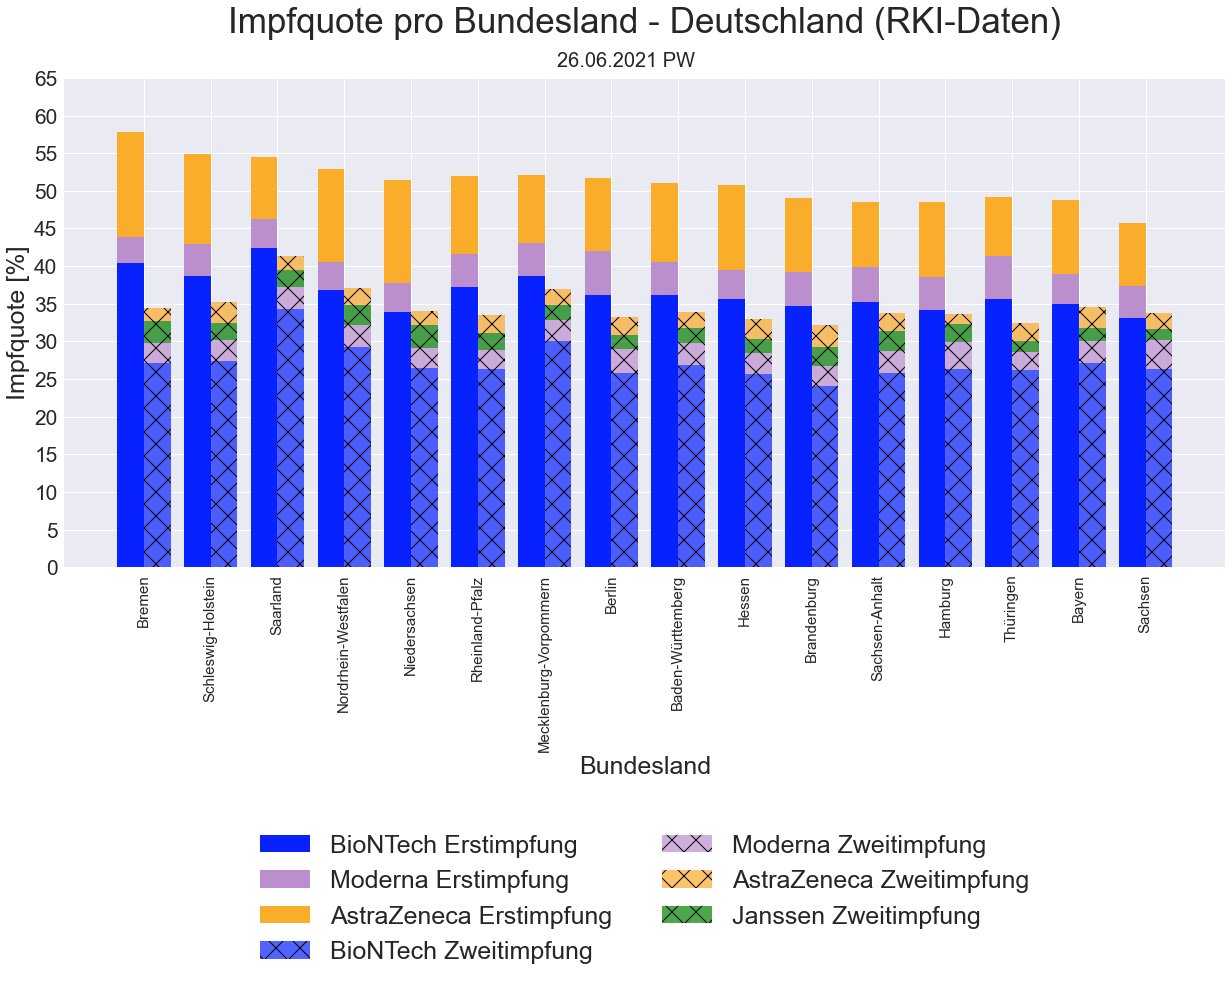

In [84]:
plt.figure(figsize=(h,v))

plt.style.use('seaborn')


w=0.40

x=df_I_EW["Bundesland"].tolist()
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]


p1 = plt.bar(x=bar1, height=df_I_EW["Impfquote_BioNTech_EI"], width = 0.4, 
             align = 'center', color = c_ger, label = "BioNTech Erstimpfung")

p2 = plt.bar(x=bar1, height=df_I_EW["Impfquote_Moderna_EI"], width = 0.4, 
             align = 'center', color = c_cz, 
             bottom=df_I_EW["Impfquote_BioNTech_EI"], label = "Moderna Erstimpfung")

p3 = plt.bar(x=bar1, height=df_I_EW["Impfquote_AstraZeneca_EI"], width = 0.4,
             align = 'center', color = c_gb, 
             bottom=  np.array(df_I_EW["Impfquote_BioNTech_EI"]) + np.array(df_I_EW["Impfquote_Moderna_EI"]), 
             label = "AstraZeneca Erstimpfung")



p4 = plt.bar(x=bar2, height=df_I_EW["Impfquote_BioNTech_ZI"], width = 0.4, 
             align = 'center', color = c_ger, label = "BioNTech Zweitimpfung", hatch="x", alpha = 0.7)

p5 = plt.bar(x=bar2, height=df_I_EW["Impfquote_Moderna_ZI"], width = 0.4, 
             align = 'center', color = c_cz, hatch="x", alpha = 0.7,
             bottom=df_I_EW["Impfquote_BioNTech_ZI"], label = "Moderna Zweitimpfung")

p6 = plt.bar(x=bar2, height=df_I_EW["Impfquote_AstraZeneca_ZI"], width = 0.4, ###
             align = 'center', color = c_gb, hatch="x", alpha = 0.7,
             bottom=  np.array(df_I_EW["Impfquote_BioNTech_ZI"]) + np.array(df_I_EW["Impfquote_Moderna_ZI"]) + np.array(df_I_EW["Impfquote_Janssen_ZI"]), 
             label = "AstraZeneca Zweitimpfung")

p7 = plt.bar(x=bar2, height=df_I_EW["Impfquote_Janssen_ZI"], width = 0.4, 
             align = 'center', color = "green", hatch="x", alpha = 0.7,
             bottom = np.array(df_I_EW["Impfquote_BioNTech_ZI"]) + np.array(df_I_EW["Impfquote_Moderna_ZI"]), 
             label = "Janssen Zweitimpfung")

# # Schriftgrößen x und y achsenwerte
plt.xticks(bar1+w/2, x,fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.yticks(np.arange(0, df_I_EW["Impfquote_EI"].max() +5 , 5))


plt.ylabel('Impfquote [%]', fontsize=size)
plt.xlabel('Bundesland', fontsize=size)

plt.title('Impfquote pro Bundesland - Deutschland (RKI-Daten)\n', fontsize=size+10)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.5),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(Laufwerk + pfad_output + name_7, dpi = dpi, bbox_inches='tight')
plt.savefig(Laufwerk + pfad_onedrive + name_7, dpi = dpi, bbox_inches='tight')

plt.show()
#plt.show()

### Berechnung Herdeinimmunität

In [85]:
df_I_EW.head(1)

,Bundesland,Einwohner,BioNTech_EI,Impfquote_BioNTech_EI,Moderna_EI,Impfquote_Moderna_EI,AstraZeneca_EI,Impfquote_AstraZeneca_EI,BioNTech_ZI,Impfquote_BioNTech_ZI,...,AstraZeneca_ZI,Impfquote_AstraZeneca_ZI,Janssen_ZI,Impfquote_Janssen_ZI,Summe_EI,Impfquote_EI,Summe_ZI,Impfquote_ZI,Summe_EI_ZI,Impfquote_EI_ZI
4,Bremen,681202.0,275742,40.4787,23147,3.39796,95329,13.9942,185165,27.1821,...,12352,1.81327,19635,2.8824,413853,60.7533,234849,34.4757,648702,95.229


In [86]:
# # v=s/t    v = 83020000*0.6 / t
# # Summe_Impfungen = df_I_EW["Summe_EI_ZI"].sum()
# # print(f'Summe_Impfungen = {Summe_Impfungen}')

# Summe_Impfungen = df_I_EW["Summe_EI_ZI"].sum()
# print(f'Summe_Impfungen  = {Summe_Impfungen} Impfungen\n')


# Ende = datetime.strptime('01.10.2021', '%d.%m.%Y')
# Tage_bis_Oktober = (Ende - now).days
# print(f'Tage_bis_Oktober = {Tage_bis_Oktober} Tage\n')

# Impfungen80 = 2*(E_ger*0.8) - Summe_Impfungen
# SOLL_Impfungen80 = int(Impfungen80*(1/Tage_bis_Oktober))
# print(f'SOLL_Impfungen80 = {SOLL_Impfungen80} Impfungen pro Tag')
# print(f'Impfungen80 = {Impfungen80} Impfungen\n')

# Impfungen60 = 2*(E_ger*0.6) - Summe_Impfungen
# SOLL_Impfungen60 = int(Impfungen60*(1/Tage_bis_Oktober))
# print(f'SOLL_Impfungen60 = {SOLL_Impfungen60} Impfungen pro Tag')
# print(f'Impfungen60 = {Impfungen60} Impfungen\n')

# Impfungen30 = 2*(E_ger*0.3) - Summe_Impfungen
# SOLL_Impfungen30 = int(Impfungen30*(1/Tage_bis_Oktober))
# print(f'SOLL_Impfungen30 = {SOLL_Impfungen30} Impfungen pro Tag')
# print(f'Impfungen30 = {Impfungen30} Impfungen\n')

# # Impfungen15 = 2*(E_ger*0.15) - Summe_Impfungen
# # SOLL_Impfungen15 = int(Impfungen15*(1/Tage_bis_Oktober))
# # print(f'SOLL_Impfungen15 = {SOLL_Impfungen15} Impfungen pro Tag')
# # print(f'Impfungen15 = {Impfungen15} Impfungen\n')

# # Impfungen5 = 2*(E_ger*0.05) - Summe_Impfungen
# # SOLL_Impfungen5 = int(Impfungen5*(1/Tage_bis_Oktober))
# # print(f'SOLL_Impfungen5 = {SOLL_Impfungen5} Impfungen pro Tag')
# # print(f'Impfungen5 = {Impfungen5} Impfungen\n')


## df_I_TS Impfungen Timeseries

In [87]:
# df_I_TS

In [88]:
# # Impfungen sheet_name der Datenquelle auslesen
# df_I_sheet = pd.read_excel(Laufwerk + pfad_input + name_input, None)
# sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
# sheet_name = [*sheet_name][3]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen
# sheet_name

In [89]:
# df_I_TS

In [90]:

# # Datenimport Impfungen
# df_I_TS = pd.read_excel(Laufwerk + pfad_input + name_input,
#                     sheet_name = sheet_name,
#                     usecols="A:C")
# df_I_TS = df_I_TS[:-8]   # drop last row
# # df_I_TS


# df_I_TS = df_I_TS.dropna(axis=0, how='any', thresh = 2)   # drop rows with more than 2 NaN values

# df_I_TS['Erstimpfung'] = df_I_TS['mindestens einmal geimpft']
# df_I_TS['Zweitimpfung'] = df_I_TS['vollständig geimpt']


# df_I_TS['Zweitimpfung'] = df_I_TS['Zweitimpfung'].fillna(0)

# df_I_TS['Summe_EI_ZI'] = df_I_TS['Erstimpfung'] + df_I_TS['Zweitimpfung']

# # df_I_TS['MA'] = df_I_TS['Summe_EI_ZI'].ewm(alpha=0.5, adjust=False).mean()
# df_I_TS['MA'] = df_I_TS['Summe_EI_ZI'].rolling(window=7,min_periods=1).mean()

# df_I_TS['MSTD_Impfungen'] = df_I_TS['Summe_EI_ZI'].rolling(window=7,min_periods=1).std()

# df_I_TS['OTG_Impfungen'] = df_I_TS['MA'] + df_I_TS['MSTD_Impfungen']
# df_I_TS['UTG_Impfungen'] = df_I_TS['MA'] - df_I_TS['MSTD_Impfungen']

# df_I_TS['SOLL_Impfungen80'] = SOLL_Impfungen80
# df_I_TS['SOLL_Impfungen60'] = SOLL_Impfungen60
# df_I_TS['SOLL_Impfungen30'] = SOLL_Impfungen30
# # df_I_TS['SOLL_Impfungen15'] = SOLL_Impfungen15
# # df_I_TS['SOLL_Impfungen5'] = SOLL_Impfungen5

# df_I_TS['cumsum_EI'] = df_I_TS['Erstimpfung'].cumsum()
# df_I_TS['cumsum_ZI'] = df_I_TS['Zweitimpfung'].cumsum()

# df_I_TS = df_I_TS.loc[df_I_TS.Erstimpfung >0, :] # nur Erstimpfungen > 0 anzeigen
# #df_I_TS

In [91]:
# df_I_TS.head(1)

## RKI - Impfungen Timeseries

In [92]:
#df_I_TS.head(5)

## 7-2 Anzahl Impfungen - SOLL Impfungen - Timeseries

In [93]:

# def y_axis_thousands(x, pos):
#    # 'The two args are the value and tick position'
#     return '{:0,d}'.format(int(x)).replace(",",".")
# formatter = FuncFormatter(y_axis_thousands)


# fig, ax = plt.subplots(figsize=(h, v*1.2))

# ax.yaxis.set_major_formatter(formatter)


# # ax0 = plt.plot(df_I_TS['Datum'],df_I_TS['cumsum_EI'], color=c_ger, marker='.', markersize = 20, linestyle = 'solid', linewidth = lwb, 
# #              label = "Impfungen\n(7-Tage Mittel)") # blau, linie, dick

# ax1 = plt.plot(df_I_TS['Datum'],df_I_TS['MA'], color="black", linestyle = 'solid', linewidth = lwb, 
#                label = "Impfungen\n(7-Tage Mittelwert)") # blau, linie, dick

# ax2 = plt.plot(df_I_TS['Datum'],df_I_TS['Summe_EI_ZI'], marker='.', linestyle='', color=c_ger, markersize = 20)

# # ax3 = plt.plot(df_I_TS['Datum'],df_I_TS['OTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, label ="+- 1 sigma")
# # ax4 = plt.plot(df_I_TS['Datum'],df_I_TS['UTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, label ="")

# ax5 = plt.plot(df_I_TS['Datum'],
#                df_I_TS['SOLL_Impfungen80'], 
#                color='#34eb46', 
#                linestyle = 'dashed', 
#                linewidth = lws, 
#                label = "SOLL-Impfungen pro Tag\num 30, 60, 80% der Bevölkerung\nbis 01.10.2021 zu impfen (2 Dosen)")


# ax6 = plt.plot(df_I_TS['Datum'],
#                df_I_TS['SOLL_Impfungen60'], 
#                color='#34eb46', 
#                linestyle = 'dashed', 
#                linewidth = lws, 
#                label = "")

# ax7 = plt.plot(df_I_TS['Datum'],
#                df_I_TS['SOLL_Impfungen30'], 
#                color='#34eb46', 
#                linestyle = 'dashed', 
#                linewidth = lws, 
#                label = "")

# # ax8 = plt.plot(df_I_TS['Datum'],
# #                df_I_TS['SOLL_Impfungen15'], 
# #                color='#34eb46', 
# #                linestyle = 'dashed', 
# #                linewidth = lws, 
# #                label = "")

# # # Schriftgrößen x und y achsenwerte
# plt.xticks(fontsize=size - 5, rotation=0)
# plt.yticks(fontsize=size - 4)

# plt.ylabel('Anzahl Impfungen', fontsize=size)
# plt.xlabel('Zeit', fontsize=size)

# plt.title('Anzahl Impfungen Deutschland (RKI-Daten)\n', fontsize=size+10)
# plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# # # fill area between lines
# # plt.fill_between(df_I_TS['Datum'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color='red',alpha=0.5)

# # Legende 
# plt.legend(loc='upper center', 
#            bbox_to_anchor=(0.5, -0.3),
#            fancybox=True, 
#            shadow=True, 
#            ncol=2, 
#            fontsize=size)

# locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
# formatter = mdates.ConciseDateFormatter(locator)
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(formatter)

# fig.savefig(Laufwerk + pfad_output + name_7_2, dpi = dpi, bbox_inches='tight')
# fig.savefig(Laufwerk + pfad_onedrive + name_7_2, dpi = dpi, bbox_inches='tight')

# plt.show()
# #plt.show()

## 7-3 Timeseries 

In [94]:

# def y_axis_thousands(x, pos):
#    # 'The two args are the value and tick position'
#     return '{:0,d}'.format(int(x)).replace(",",".")
# formatter = FuncFormatter(y_axis_thousands)

# fig, ax = plt.subplots(figsize=(h, v*1.2))

# ax.yaxis.set_major_formatter(formatter)

# ax1 = plt.plot(df_I_TS['Datum'],df_I_TS['MA'], color="black", linestyle = 'solid', linewidth = lwb, 
#                label = "Impfungen\n(7-Tage Mittelwert)") # blau, linie, dick

# ax2 = plt.plot(df_I_TS['Datum'],df_I_TS['Summe_EI_ZI'], marker='.', linestyle='', color=c_ger, markersize = 20)

# ax3 = plt.plot(df_I_TS['Datum'],df_I_TS['OTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, 
#                label ="+- 1 sigma")

# ax4 = plt.plot(df_I_TS['Datum'],df_I_TS['UTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, 
#                label ="")

# # # Schriftgrößen x und y achsenwerte
# plt.xticks(fontsize=size - 5, rotation=0)
# plt.yticks(fontsize=size - 4)

# plt.ylabel('Anzahl Impfungen', fontsize=size)
# plt.xlabel('Zeit', fontsize=size)

# plt.title('Anzahl Impfungen Deutschland (RKI-Daten)\n', fontsize=size+10)
# plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


# # # fill area between lines
# plt.fill_between(df_I_TS['Datum'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color=c_ger,alpha=0.5)

# # Legende 
# plt.legend(loc='upper center', 
#            bbox_to_anchor=(0.5, -0.3),
#            fancybox=True, 
#            shadow=True, 
#            ncol=2, 
#            fontsize=size)

# locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
# formatter = mdates.ConciseDateFormatter(locator)
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(formatter)

# fig.savefig(Laufwerk + pfad_output + name_7_3, dpi = dpi, bbox_inches='tight')
# fig.savefig(Laufwerk + pfad_onedrive + name_7_3, dpi = dpi, bbox_inches='tight')

# plt.show()
# #plt.show()

## Performance messen

In [95]:
pc = os.environ['COMPUTERNAME']
now2 = datetime.now()

# Laufzeit
x = now2 - now
x = round(x.total_seconds(),2)

print(f'performance {pc} = {x} seconds')

performance DOUG = 2.5 seconds


### Berechnung Herdeinimmunität

In [96]:
df_I_EW.head(1)

,Bundesland,Einwohner,BioNTech_EI,Impfquote_BioNTech_EI,Moderna_EI,Impfquote_Moderna_EI,AstraZeneca_EI,Impfquote_AstraZeneca_EI,BioNTech_ZI,Impfquote_BioNTech_ZI,...,AstraZeneca_ZI,Impfquote_AstraZeneca_ZI,Janssen_ZI,Impfquote_Janssen_ZI,Summe_EI,Impfquote_EI,Summe_ZI,Impfquote_ZI,Summe_EI_ZI,Impfquote_EI_ZI
4,Bremen,681202.0,275742,40.4787,23147,3.39796,95329,13.9942,185165,27.1821,...,12352,1.81327,19635,2.8824,413853,60.7533,234849,34.4757,648702,95.229


In [97]:
# v=s/t    v = 83020000*0.6 / t
# Summe_Impfungen = df_I_EW["Summe_EI_ZI"].sum()
# print(f'Summe_Impfungen = {Summe_Impfungen}')

Summe_Impfungen = df_I_EW["Summe_ZI"].sum()
print(f'Summe_Impfungen  = {Summe_Impfungen} Impfungen\n')


Ende = datetime.strptime('01.10.2021', '%d.%m.%Y')
Tage_bis_Oktober = (Ende - now).days
print(f'Tage_bis_Oktober = {Tage_bis_Oktober} Tage\n')

Impfungen100 = 1*(E_ger*1) - Summe_Impfungen
SOLL_Impfungen100 = int(Impfungen100*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen100 = {SOLL_Impfungen100} Impfungen pro Tag')
print(f'Impfungen80 = {Impfungen100} Impfungen\n')

Impfungen80 = 1*(E_ger*0.8) - Summe_Impfungen
SOLL_Impfungen80 = int(Impfungen80*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen80 = {SOLL_Impfungen80} Impfungen pro Tag')
print(f'Impfungen80 = {Impfungen80} Impfungen\n')

Impfungen60 = 1*(E_ger*0.6) - Summe_Impfungen
SOLL_Impfungen60 = int(Impfungen60*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen60 = {SOLL_Impfungen60} Impfungen pro Tag')
print(f'Impfungen60 = {Impfungen60} Impfungen\n')

Impfungen30 = 1*(E_ger*0.3) - Summe_Impfungen
SOLL_Impfungen30 = int(Impfungen30*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen30 = {SOLL_Impfungen30} Impfungen pro Tag')
print(f'Impfungen30 = {Impfungen30} Impfungen\n')


Summe_Impfungen  = 28827353 Impfungen

Tage_bis_Oktober = 96 Tage

SOLL_Impfungen100 = 564506 Impfungen pro Tag
Impfungen80 = 54192647 Impfungen

SOLL_Impfungen80 = 391548 Impfungen pro Tag
Impfungen80 = 37588647.0 Impfungen

SOLL_Impfungen60 = 218590 Impfungen pro Tag
Impfungen60 = 20984647.0 Impfungen

SOLL_Impfungen30 = -40847 Impfungen pro Tag
Impfungen30 = -3921353.0 Impfungen



## df_I_TS Impfungen Timeseries

In [98]:
# df_I_TS

In [99]:
# # Impfungen sheet_name der Datenquelle auslesen
# df_I_sheet = pd.read_excel(Laufwerk + pfad_input + name_input, None)
# sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
# sheet_name = [*sheet_name][3]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen
# sheet_name

In [100]:
print(Laufwerk)
print(pfad_input)
print(name_input)

D:\
Github\Auswertung_Covid_19\input\
Impfquotenmonitoring.xlsx


In [101]:

# Datenimport Impfungen
# df_I_TS = pd.read_excel(Laufwerk + pfad_input + name_input,
#                     sheet_name = sheet_name,
#                     usecols="A:C")
# df_I_TS = df_I_TS[:-4]   # drop last row


# df_I_TS





df_I_TS = pd.read_csv(Laufwerk + pfad_input + "Impfquotenmonitoring.csv",sep=";", decimal=",")

df_I_TS['Datum'] = pd.to_datetime(df_I_TS.Datum, utc=True)
df_I_TS = df_I_TS.dropna(axis=0, how='any', thresh = 2)   # drop rows with more than 2 NaN values


# df_I_TS['Datum'] = df_I_TS['Datum'].dt.strftime('%Y-%m-%d %r')
df_I_TS['Zweitimpfung'] = df_I_TS['Zweitimpfung'].fillna(0)
df_I_TS['MA'] = df_I_TS['Zweitimpfung'].rolling(window=7,min_periods=1).mean()


# df_I_TS['MA'] = df_I_TS['Summe_EI_ZI'].ewm(alpha=0.5, adjust=False).mean()

df_I_TS['MSTD_Impfungen'] = df_I_TS['Zweitimpfung'].rolling(window=7,min_periods=1).std()

df_I_TS['OTG_Impfungen'] = df_I_TS['MA'] + df_I_TS['MSTD_Impfungen']
df_I_TS['UTG_Impfungen'] = df_I_TS['MA'] - df_I_TS['MSTD_Impfungen']

df_I_TS['SOLL_Impfungen100'] = SOLL_Impfungen100
df_I_TS['SOLL_Impfungen80'] = SOLL_Impfungen80
df_I_TS['SOLL_Impfungen60'] = SOLL_Impfungen60
# df_I_TS['SOLL_Impfungen30'] = SOLL_Impfungen30
# df_I_TS['SOLL_Impfungen15'] = SOLL_Impfungen15
# df_I_TS['SOLL_Impfungen5'] = SOLL_Impfungen5

df_I_TS['cumsum_EI'] = df_I_TS['Erstimpfung'].cumsum()
df_I_TS['cumsum_ZI'] = df_I_TS['Zweitimpfung'].cumsum()

df_I_TS = df_I_TS.loc[df_I_TS.Zweitimpfung >0, :] # nur Erstimpfungen > 0 anzeigen


#df_I_TS

In [102]:
df_I_TS

,Datum,Erstimpfung,Zweitimpfung,Gesamtzahl verabreichter Impfstoffdosen,MA,MSTD_Impfungen,OTG_Impfungen,UTG_Impfungen,SOLL_Impfungen100,SOLL_Impfungen80,SOLL_Impfungen60,cumsum_EI,cumsum_ZI
19,2021-01-15 00:00:00+00:00,89222,802,90024,114.571429,303.127507,417.698936,-188.556079,564506,391548,218590,1097480,802
20,2021-01-16 00:00:00+00:00,56037,1018,57055,260.000000,448.391198,708.391198,-188.391198,564506,391548,218590,1153517,1820
21,2021-01-17 00:00:00+00:00,30541,17789,48330,2801.285714,6623.161851,9424.447565,-3821.876137,564506,391548,218590,1184058,19609
22,2021-01-18 00:00:00+00:00,66218,15859,82077,5066.857143,8061.478781,13128.335924,-2994.621639,564506,391548,218590,1250276,35468
23,2021-01-19 00:00:00+00:00,82441,36005,118446,10210.428571,13761.213571,23971.642143,-3550.785000,564506,391548,218590,1332717,71473
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2021-06-14 00:00:00+00:00,250840,379008,629848,516929.571429,235302.774089,752232.345518,281626.797340,564506,391548,218590,40405330,21017424
170,2021-06-15 00:00:00+00:00,371997,631711,1003708,516141.857143,234841.725323,750983.582466,281300.131820,564506,391548,218590,40777327,21649135
171,2021-06-16 00:00:00+00:00,500989,826465,1327454,514370.428571,232031.634359,746402.062930,282338.794212,564506,391548,218590,41278316,22475600
172,2021-06-17 00:00:00+00:00,421493,656505,1077998,509217.571429,227776.052158,736993.623586,281441.519271,564506,391548,218590,41699809,23132105


## RKI - Impfungen Timeseries

In [103]:
df_I_TS.dtypes

Datum                                      datetime64[ns, UTC]
Erstimpfung                                              int64
Zweitimpfung                                             int64
Gesamtzahl verabreichter Impfstoffdosen                  int64
MA                                                     float64
MSTD_Impfungen                                         float64
OTG_Impfungen                                          float64
UTG_Impfungen                                          float64
SOLL_Impfungen100                                        int64
SOLL_Impfungen80                                         int64
SOLL_Impfungen60                                         int64
cumsum_EI                                                int64
cumsum_ZI                                                int64
dtype: object

## 7-2 Anzahl Impfungen - SOLL Impfungen - Timeseries

In [104]:
print(Laufwerk) 
print(pfad_output)
print(name_7_2)

D:\
Github\Auswertung_Covid_19\output\
plot_7-2_Impfungen_Timeseries_ger.png


In [105]:
df_I_TS

,Datum,Erstimpfung,Zweitimpfung,Gesamtzahl verabreichter Impfstoffdosen,MA,MSTD_Impfungen,OTG_Impfungen,UTG_Impfungen,SOLL_Impfungen100,SOLL_Impfungen80,SOLL_Impfungen60,cumsum_EI,cumsum_ZI
19,2021-01-15 00:00:00+00:00,89222,802,90024,114.571429,303.127507,417.698936,-188.556079,564506,391548,218590,1097480,802
20,2021-01-16 00:00:00+00:00,56037,1018,57055,260.000000,448.391198,708.391198,-188.391198,564506,391548,218590,1153517,1820
21,2021-01-17 00:00:00+00:00,30541,17789,48330,2801.285714,6623.161851,9424.447565,-3821.876137,564506,391548,218590,1184058,19609
22,2021-01-18 00:00:00+00:00,66218,15859,82077,5066.857143,8061.478781,13128.335924,-2994.621639,564506,391548,218590,1250276,35468
23,2021-01-19 00:00:00+00:00,82441,36005,118446,10210.428571,13761.213571,23971.642143,-3550.785000,564506,391548,218590,1332717,71473
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2021-06-14 00:00:00+00:00,250840,379008,629848,516929.571429,235302.774089,752232.345518,281626.797340,564506,391548,218590,40405330,21017424
170,2021-06-15 00:00:00+00:00,371997,631711,1003708,516141.857143,234841.725323,750983.582466,281300.131820,564506,391548,218590,40777327,21649135
171,2021-06-16 00:00:00+00:00,500989,826465,1327454,514370.428571,232031.634359,746402.062930,282338.794212,564506,391548,218590,41278316,22475600
172,2021-06-17 00:00:00+00:00,421493,656505,1077998,509217.571429,227776.052158,736993.623586,281441.519271,564506,391548,218590,41699809,23132105


In [106]:

# def y_axis_thousands(x, pos):
#    # 'The two args are the value and tick position'
#     return '{:0,d}'.format(int(x)).replace(",",".")
# formatter = FuncFormatter(y_axis_thousands)


# fig, ax = plt.subplots(figsize=(h, v*1.2))

# ax.yaxis.set_major_formatter(formatter)


# ax1 = plt.plot(df_I_TS['Datum'],df_I_TS['MA'], color="black", linestyle = 'solid', linewidth = lwb, 
#                label = "Impfungen\n(7-Tage Mittelwert)") # blau, linie, dick

# ax2 = plt.plot(df_I_TS['Datum'],df_I_TS['Zweitimpfung'], marker='.', linestyle='', color=c_ger, markersize = 20)

# ax4 = plt.plot(df_I_TS['Datum'],
#                df_I_TS['SOLL_Impfungen100'], 
#                color='#34eb46', 
#                linestyle = 'dashed', 
#                linewidth = lws, 
#                label = "SOLL-Impfungen pro Tag\num 60, 80%, 100% der Bevölkerung\nbis 01.10.2021 zu impfen (Vollständig)")

# ax5 = plt.plot(df_I_TS['Datum'],
#                df_I_TS['SOLL_Impfungen80'], 
#                color='#34eb46', 
#                linestyle = 'dashed', 
#                linewidth = lws, 
#                label = "")


# # ax6 = plt.plot(df_I_TS['Datum'],
# #                df_I_TS['SOLL_Impfungen60'], 
# #                color='#34eb46', 
# #                linestyle = 'dashed', 
# #                linewidth = lws, 
# #                label = "")

# # # Schriftgrößen x und y achsenwerte
# plt.xticks(fontsize=size - 5, rotation=0)
# plt.yticks(fontsize=size - 4)

# plt.ylabel('Anzahl Impfungen', fontsize=size)
# plt.xlabel('Zeit', fontsize=size)

# plt.title('Anzahl Zweitimpfungen Deutschland (RKI-Daten)\n', fontsize=size+10)
# plt.suptitle(today + ' PW', fontsize=size-5, y=0.91)

# # # fill area between lines
# # plt.fill_between(df_I_TS['Datum'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color='red',alpha=0.5)

# # Legende 
# plt.legend(loc='upper center', 
#            bbox_to_anchor=(0.5, -0.3),
#            fancybox=True, 
#            shadow=True, 
#            ncol=2, 
#            fontsize=size)

# locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
# formatter = mdates.ConciseDateFormatter(locator)
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(formatter)

# fig.savefig(Laufwerk + pfad_output + name_7_2, dpi = dpi, bbox_inches='tight')
# fig.savefig(Laufwerk + pfad_onedrive + name_7_2, dpi = dpi, bbox_inches='tight')

# plt.show()
# #plt.show()

## Anzahl Impfungen kumuliert

In [107]:
# def y_axis_thousands(x, pos):
#    # 'The two args are the value and tick position'
#     return '{:0,d}'.format(int(x)).replace(",",".")
# formatter = FuncFormatter(y_axis_thousands)


# fig, ax = plt.subplots(figsize=(h, v*1.4))

# ax.yaxis.set_major_formatter(formatter)


# ax0 = plt.plot(df_I_TS['Datum'],df_I_TS['cumsum_EI'], color=c_ger, marker='', markersize = 20, 
#                linestyle = 'solid', linewidth = lwb, 
#                label = "Erstimpfungen\n(7-Tage Mittelwert)") # blau, linie, dick

# ax0 = plt.plot(df_I_TS['Datum'],df_I_TS['cumsum_ZI'], color="green", marker='', markersize = 20, 
#                linestyle = 'solid', linewidth = lwb, 
#                label = "Zweitimpfungen\n(7-Tage Mittelwert)") # blau, linie, dick

# # # Schriftgrößen x und y achsenwerte
# plt.xticks(fontsize=size - 5, rotation=0)
# plt.yticks(fontsize=size - 4)

# plt.ylabel('Anzahl Impfungen', fontsize=size)
# plt.xlabel('Zeit', fontsize=size)

# plt.title('Kumulierte Anzahl Impfungen Deutschland (RKI-Daten)\n', fontsize=size+10)
# plt.suptitle(today + ' PW', fontsize=size-5, y=0.91)

# # # fill area between lines
# # plt.fill_between(df_I_TS['Datum'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color='red',alpha=0.5)

# # Legende 
# plt.legend(loc='upper center', 
#            bbox_to_anchor=(0.5, -0.1),
#            fancybox=True, 
#            shadow=True, 
#            ncol=2, 
#            fontsize=size)

# locator = mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks)
# formatter = mdates.ConciseDateFormatter(locator)
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(formatter)

# fig.savefig(Laufwerk + pfad_output + name_7_4, dpi = dpi, bbox_inches='tight')
# fig.savefig(Laufwerk + pfad_onedrive + name_7_4, dpi = dpi, bbox_inches='tight')

# plt.show()
# #plt.show()

## dataframes speichern

In [108]:
df_EW.to_csv(Laufwerk + pfad_output + name_output_df_EW, index=False)
df_I.to_csv(Laufwerk + pfad_output + name_output_df_I, index=False)
df_I_EW.to_csv(Laufwerk + pfad_output + name_output_df_I_EW, index=False)
df_I_TS.to_csv(Laufwerk + pfad_output + name_output_df_I_TS, index=False)
# df_VOC.to_csv(Laufwerk + pfad_output + name_output_df_VOC, index=False)


